# 【第３回 課題4】画像変換(1) : Pix2Pix

In [1]:
# UEC 共通設定
import os
datadir="../dataset/"


## 画像変換

課題４では，画像変換を実験してみましょう．

以下のように，encoderとdecoderが組み合わさった，encoder-decoderネットワークを学習して，画像変換を実現します．encoderの入力は画像，decoderの出力は画像ですから，入力も出力も画像となります．

<img src="fig/pix2pix.png" width=600>

Pix2Pix と呼ばれる GANと画像変換を組み合わせた手法を試してみましょう．2017年に発表された研究です．

以下の図のように，ペアになっているデータがあれば，例えば，画像からエッジ画像だけでなく，その逆のエッジ画像から画像など，どちらの方向の変換でも可能です．これはGANという画像生成的な方法で学習しているため，情報量が圧倒的に少ない線画からでも，元の画像に似たような画像を生成することができます．実際には，エッジ画像の方が100次元のランダムベクトルよりもはるかに情報量は多いので，生成に比べたら容易です．

<img src="fig/pix2pix2.png" width=600>

[線画着色サービス PaintChainer](https://paintschainer.preferred.tech/)が使っている「着色AI」の正体がこの Pix2Pixです．


## エッジ画像から食事画像の生成

ここでは，用意した食事画像とそのエッジ画像のペアを学習データとして，「線画着色」の食事版を実現してみましょう．

例えば，線画着色オムライシバージョンを学習できれば，以下のように線画を入力するとオムライス画像が生成できるはずです．

<img src="fig/ompix.png" width=600>

In [33]:
# This code is based on https://github.com/eriklindernoren/Keras-GAN
from __future__ import print_function, division
import scipy

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models,transforms
import statistics

import time
import matplotlib.pyplot as plt
import sys
from data_loader_px import DataLoader
import numpy as np
import os

In [3]:
img_size = 128
food = "omurice"

img_shape = (img_size, img_size, 3)
data_loader = DataLoader(datadir=datadir+"foodimg"+str(img_size),
                         dataset_name=food,img_res=(img_size,img_size))
outdir='result/pix2pix_1'
os.makedirs(outdir, exist_ok=True)
epochs=40
batch_size=15
sample_interval=200



In [4]:

class build_generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = self.conv_bn_relu(1, 32, kernel_size=5) # 32x96x96
        self.enc2 = self.conv_bn_relu(32, 64, kernel_size=3, pool_kernel=4)  # 64x24x24
        self.enc3 = self.conv_bn_relu(64, 128, kernel_size=3, pool_kernel=2)  # 128x12x12
        self.enc4 = self.conv_bn_relu(128, 256, kernel_size=3, pool_kernel=2)  # 256x6x6
        
        self.dec1 = self.conv_bn_relu(256, 128, kernel_size=3, pool_kernel=-2)  # 128x12x12
        self.dec2 = self.conv_bn_relu(128 + 128, 64, kernel_size=3, pool_kernel=-2)  # 64x24x24
        self.dec3 = self.conv_bn_relu(64 + 64, 32, kernel_size=3, pool_kernel=-4)  # 32x96x96
        self.dec4 = nn.Sequential(
            nn.Conv2d(32 + 32, 3, kernel_size=5, padding=2),
            nn.Tanh()
        )

    def conv_bn_relu(self, in_ch, out_ch, kernel_size=3, pool_kernel=None):
        layers = []
        if pool_kernel is not None:
            if pool_kernel > 0:
                layers.append(nn.AvgPool2d(pool_kernel))
            elif pool_kernel < 0:
                layers.append(nn.UpsamplingNearest2d(scale_factor=-pool_kernel))
        layers.append(nn.Conv2d(in_ch, out_ch, kernel_size, padding=(kernel_size - 1) // 2))
        layers.append(nn.BatchNorm2d(out_ch))
        layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)
    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.enc4(x3)
        out = self.dec1(x4)
        out = self.dec2(torch.cat([out, x3], dim=1))
        out = self.dec3(torch.cat([out, x2], dim=1))
        out = self.dec4(torch.cat([out, x1], dim=1))
        return out

In [5]:

class build_discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = self.conv_bn_relu(4, 16, kernel_size=5, reps=1) # fake/true color + gray
        self.conv2 = self.conv_bn_relu(16, 32, pool_kernel=4)
        self.conv3 = self.conv_bn_relu(32, 64, pool_kernel=2)
        self.conv4 = self.conv_bn_relu(64, 128, pool_kernel=2)
        self.conv5 = self.conv_bn_relu(128, 256, pool_kernel=2)
        self.out_patch = nn.Conv2d(256, 1, kernel_size=1) #1x3x3

    def conv_bn_relu(self, in_ch, out_ch, kernel_size=3, pool_kernel=None, reps=2):
        layers = []
        for i in range(reps):
            if i == 0 and pool_kernel is not None:
                layers.append(nn.AvgPool2d(pool_kernel))
            layers.append(nn.Conv2d(in_ch if i == 0 else out_ch,
                                    out_ch, kernel_size, padding=(kernel_size - 1) // 2))
            layers.append(nn.BatchNorm2d(out_ch))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv5(self.conv4(self.conv3(self.conv2(self.conv1(x)))))
        return self.out_patch(out)

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

def sample_images(epoch, batch_i):
    #os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
    r, c = 3, 5

    real_color, gray = data_loader.load_data(batch_size=5, is_testing=True)
    input_gray=gray.transpose(0,3,1, 2)
    input_gray=input_gray[:,0,np.newaxis,:,:]
    input_gray= torch.from_numpy(input_gray.astype(np.float32)).clone()
    input_gray = input_gray.to(device)


    fake_A = model_G(input_gray)
    fake_A=fake_A.to('cpu').detach().numpy().copy()
    fake_A=fake_A.transpose(0,2,3, 1)
    gen_imgs = np.concatenate([gray, fake_A, real_color])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    titles = ['Input', 'Generated', 'Original']
    fig, axs = plt.subplots(r, c, figsize=(10,6))
    cnt = 0
    for i in range(r):
       for j in range(c):
           axs[i,j].imshow(gen_imgs[cnt])
           axs[i,j].set_title(titles[i])
           axs[i,j].axis('off')
           cnt += 1
    fig.savefig("%s/%d_%d.png" % (outdir, epoch, batch_i))
    
    display.clear_output(wait = True)
    display.display(fig)
    plt.close()

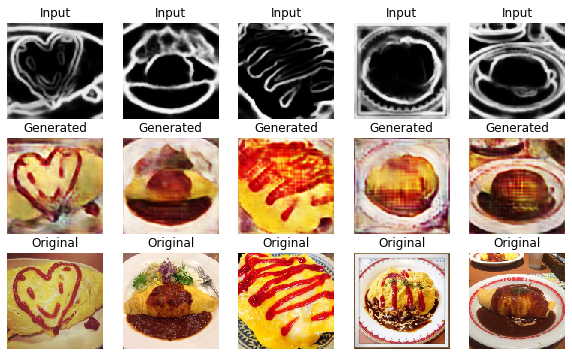

[Epoch 39/40] [Batch 20/66] time: 249.2450876235962
[Epoch 39/40] [Batch 40/66] time: 251.02333521842957
[Epoch 39/40] [Batch 60/66] time: 252.83267092704773
log_loss_G_sum = 30.47661913358248 (1.8484413530964119, 28.62817773085374) log_loss_D = 0.7533741772174836


In [7]:
device = "cuda"
torch.backends.cudnn.benchmark = True

model_G, model_D = build_generator(), build_discriminator()
#model_G, model_D = nn.DataParallel(model_G), nn.DataParallel(model_D)
model_G, model_D = model_G.to(device), model_D.to(device)
params_G = torch.optim.Adam(model_G.parameters(),
        lr=0.0002, betas=(0.5, 0.999))
params_D = torch.optim.Adam(model_D.parameters(),
        lr=0.0002, betas=(0.5, 0.999))

# ロスを計算するためのラベル変数 (PatchGAN)
patch=int(img_size/2**5)
ones = torch.ones(512, 1, patch, patch).to(device)
zeros = torch.zeros(512, 1, patch, patch).to(device)

# 損失関数
bce_loss = nn.BCEWithLogitsLoss()
mae_loss = nn.L1Loss()

# エラー推移
result = {}
result["log_loss_G_sum"] = []
result["log_loss_G_bce"] = []
result["log_loss_G_mae"] = []
result["log_loss_D"] = []
start = time.time()
# 訓練
for epoch in range(epochs):
    log_loss_G_sum, log_loss_G_bce, log_loss_G_mae, log_loss_D = [], [], [], []

 #   for (real_color, input_gray), _ in tqdm(dataset):
    for batch_i, (real_color, input_gray) in enumerate(data_loader.load_batch(batch_size)):
   
              
        real_color=real_color.transpose(0,3,1, 2)
        input_gray=input_gray.transpose(0,3,1, 2)
        input_gray=input_gray[:,0,np.newaxis,:,:]
        real_color=torch.from_numpy(real_color.astype(np.float32)).clone()
        input_gray= torch.from_numpy(input_gray.astype(np.float32)).clone()
        real_color, input_gray = real_color.to(device), input_gray.to(device)
        batch_len = len(real_color)
        # Gの訓練
        # 偽のカラー画像を作成
        fake_color = model_G(input_gray)
        
        # 偽画像を一時保存
        fake_color_tensor = fake_color.detach()

        # 偽画像を本物と騙せるようにロスを計算
        LAMBD = 100.0 # BCEとMAEの係数
        cat=torch.cat([fake_color, input_gray], dim=1)
        out =model_D(cat)
        loss_G_bce = bce_loss(out, ones[:batch_len])
        loss_G_mae = LAMBD * mae_loss(fake_color, real_color)
        loss_G_sum = loss_G_bce + loss_G_mae

        log_loss_G_bce.append(loss_G_bce.item())
        log_loss_G_mae.append(loss_G_mae.item())
        log_loss_G_sum.append(loss_G_sum.item())

        # 微分計算・重み更新
        params_D.zero_grad()
        params_G.zero_grad()
        loss_G_sum.backward()
        params_G.step()

        # Discriminatoの訓練
        # 本物のカラー画像を本物と識別できるようにロスを計算
        real_out =model_D(torch.cat([real_color, input_gray], dim=1))
        loss_D_real = bce_loss(real_out, ones[:batch_len])

        # 偽の画像の偽と識別できるようにロスを計算
        fake_out = model_D(torch.cat([fake_color_tensor, input_gray], dim=1))
        loss_D_fake = bce_loss(fake_out, zeros[:batch_len])

        # 実画像と偽画像のロスを合計
        loss_D = loss_D_real + loss_D_fake
        log_loss_D.append(loss_D.item())

        # 微分計算・重み更新
        params_D.zero_grad()
        params_G.zero_grad()
        loss_D.backward()
        params_D.step()
        tm = time.time() - start
        if batch_i % 20==0:
            print ("[Epoch %d/%d] [Batch %d/%d] time: %s" % (epoch, epochs,batch_i, data_loader.n_batches, tm))
             # If at save interval => save generated image samples
        if batch_i % sample_interval == 0:
            sample_images(epoch, batch_i)
        
    result["log_loss_G_sum"].append(statistics.mean(log_loss_G_sum))
    result["log_loss_G_bce"].append(statistics.mean(log_loss_G_bce))
    result["log_loss_G_mae"].append(statistics.mean(log_loss_G_mae))
    result["log_loss_D"].append(statistics.mean(log_loss_D))
                                  

    print(f"log_loss_G_sum = {result['log_loss_G_sum'][-1]} " +
    f"({result['log_loss_G_bce'][-1]}, {result['log_loss_G_mae'][-1]}) " +
    f"log_loss_D = {result['log_loss_D'][-1]}")



In [9]:
torch.save(model_G.state_dict(),'%s/pix2pix_gen_edge2%s.h5' % (outdir,food))
print("saved the models as '%s/pix2pix_gen_edge2%s.h5'" % (outdir,food))

saved the models as 'result/pix2pix_1/pix2pix_gen_edge2omurice.h5'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


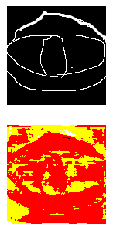

In [55]:
import io
import urllib.request
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline
from IPython import display

gen = build_generator()
gen.load_state_dict(torch.load('%s/pix2pix_gen_edge2%s.h5' % (outdir,food)))

imgdir="./"

#for p in range(pn):
r=2
c=1

fig = plt.figure(figsize=(16,4))
for i in range(c):
#    f = io.BytesIO(urllib.request.urlopen(imglist[i]).read())
    inputs = Image.open(imgdir+"hand.png").convert('L')
  

    
    ax = fig.add_subplot(r,c,i+1)
    plt.gray()
    ax.imshow(inputs,vmin=0,vmax=255)
    ax.axis('off')
    
    #print(inputs)
 
    #inputs=inputs[:,:,:,]
  
    preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5],
        std=[0.5]
    )
])
    input_gray=preprocess(inputs)
    img_batch = input_gray[None]
    gen.eval()
    gen_imgs = gen(img_batch)  
    gen_imgs = gen_imgs.detach().numpy() * 255  
    gen_imgs = (gen_imgs + 1.0) * 127.5       
    gen_imgs =gen_imgs.transpose(0,2,3, 1)
    
    #(gen_imgs[0]).save(outdir+'/%s_edge2color.jpg'%food)

    #print(gen_imgs[0])
    ax = fig.add_subplot(r,c,i+1+c)
    tempimg=gen_imgs[0]
    #print(tempimg.shape)
    ax.imshow(tempimg,vmin=0,vmax=255)
    ax.axis('off')